In [ ]:
!pip install alive-progress



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210077 sha256=92e9cf1385f5bc929d9a0f4d3c53bb2cdd18235257068fb299994fe6da859266
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


Running on device: CUDA
Files already downloaded and verified
Files already downloaded and verified
Train set accuracy: 99.5%
Test set accuracy: 88.5%
tensor([0.0003, 0.0001, 0.0004,  ..., 0.0002, 0.0160, 0.0028])


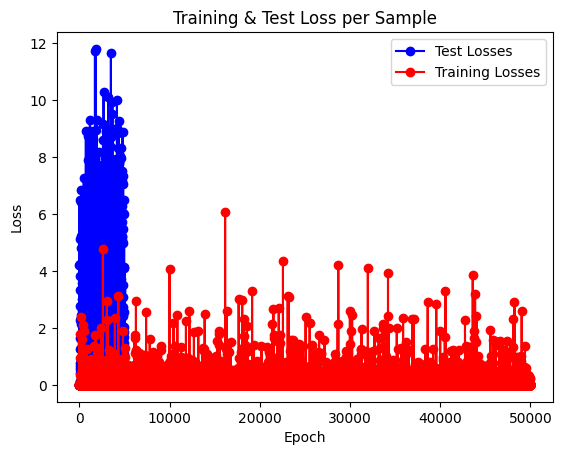

In [ ]:
from test_loss import main
main()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from alive_progress import alive_bar
import os
import shutil
from pathlib import Path
import random
from torchvision.datasets.utils import download_url
import tarfile

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RNG = torch.Generator().manual_seed(42)

def setup_model():
    local_path = "weights_resnet18_cifar10.pth"
    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    model = resnet18(weights=None, num_classes=10)
    model.load_state_dict(weights_pretrained)
    model.to(DEVICE)
    model.eval()
    return model

def compute_data_losses(net, loader):
    """Compute losses per sample"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets)
        all_losses.extend(losses.cpu().detach().numpy())

    return torch.tensor(all_losses)

def accuracy(net, loader):
    """Compute Accuracy on a dataset given by loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

def membership_inference(net, data_paths, label, train_data_paths, transform):
    """Compute membership inference per sample"""
    criterion = nn.CrossEntropyLoss(reduction="none")

    member_correct_pred = 0
    wrong_member_pred = 0
    non_member_correct_pred = 0
    wrong_non_member_pred = 0
    member_total = 0
    non_member_total = 0

    for path, true_label in zip(data_paths, label):
        from PIL import Image
        img = Image.open(path)  # Convert PosixPath to string
        transformed_image = transform(img).unsqueeze(0).to(DEVICE)
        net.eval()
        with torch.inference_mode():
            logits = net(transformed_image)
            losses = criterion(logits, torch.tensor([true_label]).to(DEVICE))

        for idx, loss in enumerate(losses):
            if loss <= 0.000600:  # Threshold for membership
                member_total += 1
                if str(path) in [str(train_path) for train_path in train_data_paths]:
                    member_correct_pred += 1
                else:
                    wrong_member_pred += 1

            else:
                non_member_total += 1
                if str(path) not in [str(train_path) for train_path in train_data_paths]:
                    non_member_correct_pred += 1
                else:
                    wrong_non_member_pred += 1


    member_precision = (member_correct_pred / (member_correct_pred + wrong_non_member_pred)) * 100 if member_total > 0 else 0
    non_member_precision = (non_member_correct_pred / (non_member_correct_pred + wrong_member_pred)) * 100 if non_member_total > 0 else 0
    overall_accuracy = ((member_correct_pred + non_member_correct_pred) / (member_total + non_member_total)) * 100 if (member_total + non_member_total) > 0 else 0

    return member_total, non_member_total, \
        member_correct_pred, non_member_correct_pred, \
        wrong_non_member_pred, wrong_member_pred, \
        member_precision, non_member_precision, \
        overall_accuracy

def main():

    print("Running on device:", DEVICE.upper())

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

    # download and pre-process CIFAR10
    print("Creating cifar10 dataset...")
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
    download_url(dataset_url, '.')

    with tarfile.open("./cifar10.tgz", "r:gz") as tar:
        tar.extractall(path="./data")

    data_dir = "/content/data/cifar10"

    train_set = ImageFolder(data_dir + '/train', transform=transform)
    test_set = ImageFolder(data_dir + '/test', transform=transform)

    # Create dataloaders
    train_loader = DataLoader(train_set, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    # create data paths
    test_data_paths = random.sample(list(Path(data_dir, "test").glob("*/*.png")), 500)
    train_data_paths = random.sample(list(Path(data_dir, "train").glob("*/*.png")), 500)

    train_test_paths = test_data_paths + train_data_paths
    random.shuffle(train_test_paths)


    class_to_label = {label: idx for idx, label in enumerate(sorted(set(path.parent.stem for path in train_test_paths)))}
    train_test_labels = [class_to_label[path.parent.stem] for path in train_test_paths]

    model = setup_model()
    model.eval()

    member_total, non_member_total, \
    member_correct_pred, non_member_correct_pred, \
    wrong_non_member_pred, wrong_member_pred, \
    member_precision, non_member_precision, \
    overall_accuracy = membership_inference(model, train_test_paths, train_test_labels, train_data_paths, transform)

    print(f'Total train: {len(train_data_paths)}, Total test: {len(test_data_paths)}')
    print('---'*45)
    print(f'Number of train_member predicted: {member_total}')
    print(f'Number of non_member predicted: {non_member_total}')
    print(f'correct_member (True positive): {member_correct_pred}')
    print(f'correct_non_member (True negative): {non_member_correct_pred}')
    print(f'wrong_member (False positive): {wrong_member_pred}')
    print(f'wrong_non_member (False negative): {wrong_non_member_pred}')
    print(f'Member precision: {member_precision:.2f}%')
    print(f'Non-Member precision: {non_member_precision:.2f}%')
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

if __name__ == "__main__":
    main()  # Retrieve model and train_test_dataloader


NameError: ignored

In [ ]:
def membership_inference(net, train_data, test_data, combined_data, train_loader, test_loader, train_test_dataloader, thresholds):
    """Compute membership inference per sample for different thresholds"""
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = compute_data_losses(net, train_loader)

    non_member_difference = []
    member_difference = []

    target_num_member = len(train_data)
    target_num_non_member = len(test_data)

    for threshold in thresholds:
        member_total = 0
        non_member_total = 0

        for inputs, targets in train_test_dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            logits = net(inputs)
            losses = criterion(logits, targets)

            for idx, loss in enumerate(losses):
                if loss <= threshold:
                    member_total += 1
                else:
                    non_member_total += 1

        # Calculate the absolute difference between predicted member and non-member samples
        member_difference.append(abs(member_total - target_num_member))
        non_member_difference.append(abs(non_member_total - target_num_non_member))

    return member_difference, non_member_difference

def main():
    print("Running on device:", DEVICE.upper())

    # download and pre-process CIFAR10
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

    held_out_train = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    )

    train_set, _ = torch.utils.data.random_split(held_out_train, [0.0078125, 0.9921875], generator=RNG)
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

    held_out_test = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )

    test_set, _ = torch.utils.data.random_split(held_out_test, [0.0625, 0.9375], generator=RNG)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

    combined_dataset = ConcatDataset([train_set, test_set])

    train_test_dataloader = torch.utils.data.DataLoader(combined_dataset, batch_size=64, shuffle=True)
    model = setup_model()
    model.eval()

    thresholds = [0.0251, 0.2252, 1.0253, 2.0254, 3.0255, 3.5256]
    member_difference, non_member_difference = membership_inference(model, train_set, test_set, combined_dataset, train_loader, test_loader, train_test_dataloader, thresholds)
    print(f'thresholds: {thresholds}')
    print(f'member_difference: {member_difference}')
    print(f'non_member_difference: {non_member_difference}')

if __name__ == "__main__":
    main()  # Retrieve model and train_test_dataloader


Running on device: CPU
Files already downloaded and verified
Files already downloaded and verified
thresholds: [0.0251, 0.2252, 1.0253, 2.0254, 3.0255, 3.5256]
member_difference: [424, 516, 551, 569, 581, 590]
non_member_difference: [424, 516, 551, 569, 581, 590]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, ConcatDataset

import torchvision
from torchvision import transforms
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RNG = torch.Generator().manual_seed(42)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
    )

held_out_train = torchvision.datasets.CIFAR10(
       root="./data", train=True, download=True, transform=transform
)

train_set, _ = torch.utils.data.random_split(held_out_train, [0.125, 0.875], generator=RNG)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)


held_out_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

test_set, _ = torch.utils.data.random_split(held_out_test, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)


combined_dataset = ConcatDataset([train_set, test_set])

train_test_dataloader = torch.utils.data.DataLoader(combined_dataset, batch_size=100, shuffle=True)




Files already downloaded and verified
Files already downloaded and verified


In [ ]:
a,b = train_set[0]
print(a.shape)
print("Sample inputs from test_loader:")
for batch_idx, (inputs, targets) in enumerate(train_test_dataloader):
    if batch_idx >= 2:
      break
    print(inputs.shape , targets)

torch.Size([3, 32, 32])
Sample inputs from test_loader:
torch.Size([100, 3, 32, 32]) tensor([7, 3, 7, 3, 4, 9, 9, 6, 7, 9, 8, 9, 8, 5, 6, 1, 6, 3, 9, 3, 0, 2, 7, 9,
        4, 8, 9, 4, 3, 6, 3, 0, 9, 1, 9, 1, 6, 2, 0, 8, 9, 2, 4, 8, 9, 0, 4, 1,
        6, 7, 9, 4, 4, 5, 9, 3, 8, 6, 8, 7, 6, 0, 1, 1, 9, 3, 3, 7, 4, 9, 2, 4,
        1, 8, 9, 6, 6, 4, 6, 1, 3, 9, 4, 3, 1, 2, 6, 8, 6, 7, 7, 7, 9, 1, 4, 2,
        7, 5, 2, 3])
torch.Size([100, 3, 32, 32]) tensor([4, 2, 0, 3, 6, 8, 4, 5, 7, 0, 9, 9, 1, 4, 7, 1, 8, 8, 2, 4, 3, 5, 0, 5,
        6, 7, 1, 5, 4, 3, 1, 8, 0, 8, 8, 7, 0, 4, 4, 5, 2, 7, 4, 0, 1, 6, 7, 2,
        5, 8, 5, 9, 5, 4, 2, 1, 0, 9, 1, 2, 2, 2, 8, 7, 1, 0, 5, 1, 1, 5, 7, 7,
        7, 5, 3, 5, 0, 5, 7, 5, 7, 6, 0, 3, 9, 4, 5, 9, 8, 9, 6, 4, 2, 3, 6, 2,
        3, 3, 5, 9])


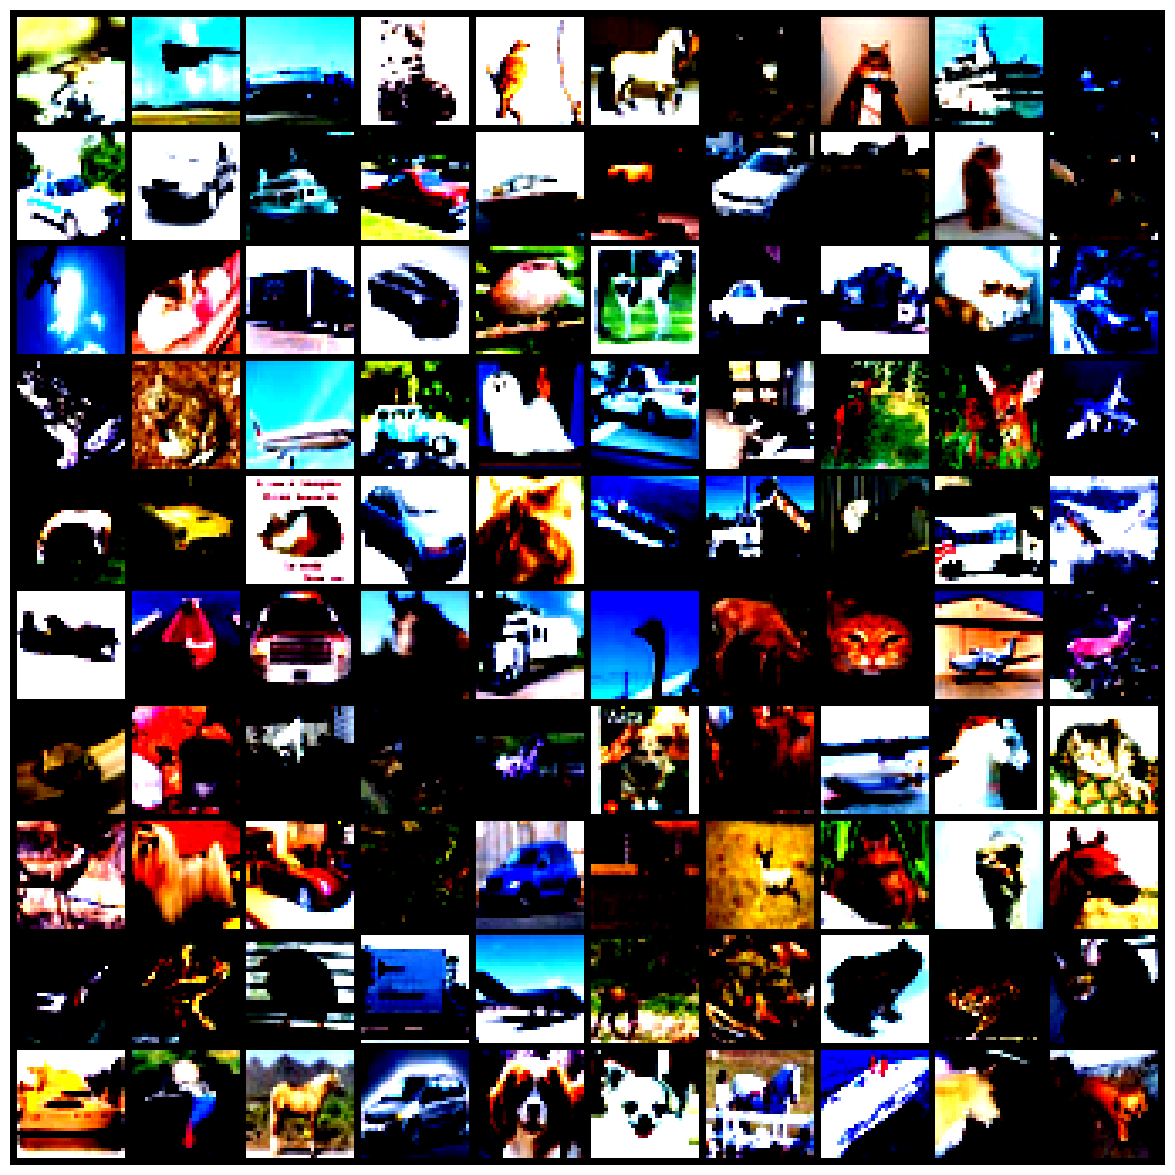

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Iterate over the first batch of the dataloader
for batch_idx, (data, labels) in enumerate(train_test_dataloader):
    # Plot the images from the first batch
    grid = torchvision.utils.make_grid(data, nrow=10)  # Assuming batch size is 100, change nrow accordingly
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break  # Exit the loop after the first batch is processed


Please follow the following steps to edit the code above accordingly:
1. Create the target model using pretrained resnet18 and cifar10 dataset.
2. Create shadow dataset (train and test) from randomly sampling 2/3 of the cifar10 data samples.
3. Create shadow model  with the shadow dataset .
4. Repeat step 2 and 3 to create 5 shadow models with varying sets but overlapping training datapoints.
5. For each shadow model, take equal number of it's train and test datapoints (in this case 10) and make predictions to get the

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
import os
import shutil
from pathlib import Path
import random
from torchvision.datasets.utils import download_url
import tarfile

In [8]:
print("Creating cifar10 dataset...")
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

with tarfile.open("./cifar10.tgz", "r:gz") as tar:
      tar.extractall(path="./data")

Creating cifar10 dataset...


NameError: ignored

In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def setup_model(model_path):
    local_path = model_path
    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    model = resnet18(weights=None, num_classes=10)
    model.load_state_dict(weights_pretrained)
    model.to(DEVICE)
    model.eval()
    return model

class ShadowNet(nn.Module):
    def __init__(self, num_classes, use_batchnorm=True, use_dropout=True):
        super(ShadowNet, self).__init__()

        # Load the pre-trained ResNet18 model
        pretrained_model = setup_model("weights_resnet18_cifar10.pth")

        # Extract layers from the pre-trained ResNet18
        self.conv1 = pretrained_model.conv1
        self.bn1 = pretrained_model.bn1
        self.relu = pretrained_model.relu
        self.maxpool = pretrained_model.maxpool
        self.layer1 = pretrained_model.layer1
        self.layer2 = pretrained_model.layer2
        self.layer3 = pretrained_model.layer3
        self.layer4 = pretrained_model.layer4

        # Custom fully connected layers for CIFAR-10
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Additional layers for improving model performance
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout

        if self.use_batchnorm:
            self.bn2 = nn.BatchNorm1d(512)  # Batch Normalization before the FC layer

        if self.use_dropout:
            self.dropout = nn.Dropout(0.5)  # Dropout layer with a dropout rate of 0.5

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        if self.use_batchnorm:
            x = self.bn2(x)

        if self.use_dropout:
            x = self.dropout(x)

        x = self.fc(x)

        return x

    def enable_dropout(self):
        for m in self.modules():
            if isinstance(m, nn.Dropout):
                m.train()

# Optional: Print the architecture of the shadow model
shadow_model = ShadowNet(num_classes=10, use_batchnorm=False, use_dropout=True)
#print(shadow_model)


In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.auto import tqdm


# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_classes = 10
num_samples_per_shadow = 25000
batch_size = 64
learning_rate = 0.001
epochs = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
cifar_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)


# Create train, validation, and test datasets
train_datasets = []
val_datasets = []
test_datasets = []

for _ in range(3):
    # Train and validation split for shadow model
    train_data, val_data = random_split(cifar_dataset, [num_samples_per_shadow, (len(cifar_dataset) - num_samples_per_shadow)])
    test_data, _ = random_split(cifar_test_dataset, [5000, len(cifar_test_dataset) - 5000])

    train_datasets.append(train_data)
    val_datasets.append(val_data)
    test_datasets.append(test_data)

# Create dataloaders for train, validation, and test datasets
train_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]
val_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in val_datasets]
test_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=False) for dataset in test_datasets]


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Function to train a shadow model
def train_shadow_model(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.6)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


    model.to(device)  # Move the model to the GPU if available

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted_train = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted_train.eq(labels).sum().item()

        scheduler.step()

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, predicted_val = val_outputs.max(1)
                total_val += val_labels.size(0)
                correct_val += predicted_val.eq(val_labels).sum().item()


        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss / len(train_loader):.4f}, '
              f'Train Accuracy: {100 * correct_train / total_train:.2f}%, '
              f'Val Loss: {val_loss / len(val_loader):.4f}, '
              f'Val Accuracy: {100 * correct_val / total_val:.2f}%')

# Train three shadow models
# Train three shadow models
shadow_models = []
for i, (shadow_train_loader, shadow_val_loader) in enumerate(zip(train_loaders, val_loaders)):
    print(f"Training Shadow Model {i+1}")

    # Create an instance of the ShadowNet
    shadow_model = ShadowNet(num_classes=num_classes, use_batchnorm=True, use_dropout=True)
    shadow_model.to(device)

    # Train the shadow model
    train_shadow_model(shadow_model, shadow_train_loader, shadow_val_loader, epochs=epochs)

    # Save the trained shadow model
    torch.save(shadow_model.state_dict(), f'shadow_model_{i+1}.pth')

    shadow_models.append(shadow_model)

print("Training of Shadow Models complete.")




Training Shadow Model 1
Epoch 1/10, Train Loss: 0.4941, Train Accuracy: 83.88%, Val Loss: 0.4638, Val Accuracy: 84.44%
Epoch 2/10, Train Loss: 0.3422, Train Accuracy: 88.63%, Val Loss: 0.4822, Val Accuracy: 83.78%
Epoch 3/10, Train Loss: 0.2678, Train Accuracy: 90.96%, Val Loss: 0.5287, Val Accuracy: 83.02%
Epoch 4/10, Train Loss: 0.2169, Train Accuracy: 92.92%, Val Loss: 0.5558, Val Accuracy: 82.77%
Epoch 5/10, Train Loss: 0.1748, Train Accuracy: 94.10%, Val Loss: 0.5385, Val Accuracy: 83.95%
Epoch 6/10, Train Loss: 0.1631, Train Accuracy: 94.54%, Val Loss: 0.6259, Val Accuracy: 82.09%
Epoch 7/10, Train Loss: 0.1389, Train Accuracy: 95.40%, Val Loss: 0.5822, Val Accuracy: 83.72%
Epoch 8/10, Train Loss: 0.0571, Train Accuracy: 98.22%, Val Loss: 0.4750, Val Accuracy: 86.49%
Epoch 9/10, Train Loss: 0.0191, Train Accuracy: 99.61%, Val Loss: 0.4864, Val Accuracy: 86.71%
Epoch 10/10, Train Loss: 0.0105, Train Accuracy: 99.84%, Val Loss: 0.4965, Val Accuracy: 87.02%
Training Shadow Model 2
E

In [4]:
def load_model(model_path, model_class, num_classes):
    local_path = model_path
    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    # Initialize the model
    model = model_class(num_classes)
    model.load_state_dict(weights_pretrained)
    model.to(DEVICE)

    return model

In [9]:
import pandas as pd
torch.manual_seed(42)

# Function to create an attack dataset using predictions from the shadow model
def create_attack_dataset(shadow_model, dataloader, is_member=True):
    shadow_model.to(device)
    shadow_model.eval()
    all_predictions = []
    labels = []

    with torch.no_grad():
        for inputs, lbl in tqdm(dataloader):
            inputs, lbl = inputs.to(device), lbl.to(device)
            logits = shadow_model(inputs)
            predictions = torch.softmax(logits, dim=1)
            top_k_values = torch.topk(predictions, k=3).values
            all_predictions.extend(top_k_values.cpu().detach().numpy())
            labels.extend([1 if is_member else 0] * len(predictions))

    return np.round(np.array(all_predictions), 7), np.array(labels)

#get shadow models
shadow_model_1 = load_model('./shadow_model_1.pth', ShadowNet, num_classes=10)
shadow_model_2 = load_model('./shadow_model_2.pth', ShadowNet, num_classes=10)
shadow_model_3 = load_model('./shadow_model_3.pth', ShadowNet, num_classes=10)

#get shadow models

# Create attack dataset for members
print(f"Create attack dataset for members")
predictions_members_1, labels_members_1 = create_attack_dataset(shadow_model_1, train_loaders[0], is_member=True)
predictions_members_2, labels_members_2 = create_attack_dataset(shadow_model_2, train_loaders[1], is_member=True)
predictions_members_3, labels_members_3 = create_attack_dataset(shadow_model_3, train_loaders[2], is_member=True)

# Create attack dataset for non-members
print(f"Create attack dataset for non-members")
predictions_non_members_1, labels_non_members_1 = create_attack_dataset(shadow_model_1, test_loaders[0], is_member=False)
predictions_non_members_2, labels_non_members_2 = create_attack_dataset(shadow_model_2, test_loaders[1], is_member=False)
predictions_non_members_3, labels_non_members_3 = create_attack_dataset(shadow_model_3, test_loaders[2], is_member=False)

# Combine the member and non-member datasets
attack_prob_input = np.concatenate(
    [predictions_members_1, predictions_members_2, predictions_members_3,
     predictions_non_members_1, predictions_non_members_2, predictions_non_members_3],
    axis=0
)
attack_labels = np.concatenate(
    [labels_members_1, labels_members_2, labels_members_3,
     labels_non_members_1, labels_non_members_2, labels_non_members_3],
    axis=0
)

# Shuffle the data
shuffle_indices = np.random.permutation(len(attack_labels))
attack_inputs = attack_prob_input[shuffle_indices]
attack_labels = attack_labels[shuffle_indices]

# Create a DataFrame with column names p1, p2, ..., p10
column_names = [f'p{i}' for i in range(1, attack_inputs.shape[1] + 1)]
attack_data = pd.DataFrame(attack_inputs, columns=column_names)
attack_data['labels'] = attack_labels


# Convert to PyTorch tensors
attack_inputs_tensor = torch.FloatTensor(attack_inputs)
attack_labels_tensor = torch.LongTensor(attack_labels)

# Create DataLoader for training
attack_dataset = torch.utils.data.TensorDataset(attack_inputs_tensor, attack_labels_tensor)
attack_loader = torch.utils.data.DataLoader(attack_dataset, batch_size=64, shuffle=True)
#print(len(attack_loader))
print(f'All done!\nlength of attack dataset: {len(attack_inputs)}')

attack_data.head()


Create attack dataset for members


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Create attack dataset for non-members


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

All done!
length of attack dataset: 90000


,p1,p2,p3,labels
0,0.998658,0.000793,0.000399,0
1,0.998972,0.000927,0.000031,1
2,0.999104,0.000185,0.000149,1
3,0.999203,0.000386,0.000237,1
4,0.999989,0.000006,0.000002,1


In [10]:
len(attack_inputs)

90000

In [11]:
attack_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p1      90000 non-null  float32
 1   p2      90000 non-null  float32
 2   p3      90000 non-null  float32
 3   labels  90000 non-null  int64  
dtypes: float32(3), int64(1)
memory usage: 1.7 MB


#Member/Non-member Binary Classification

Xgboost Classifier

ROC AUC score: 0.7116
Train Accuracy (XGBoost): 86.86%
Test Accuracy (XGBoost): 86.76%


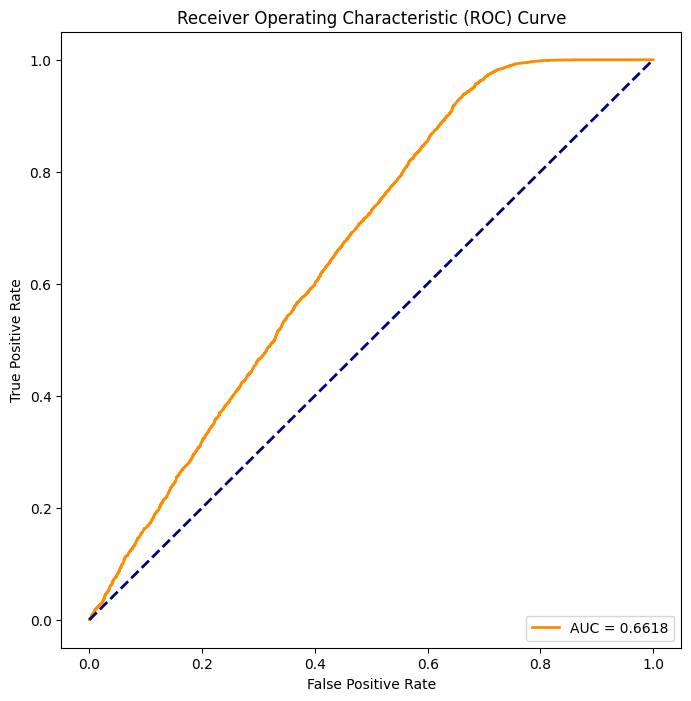

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Combine the member and non-member datasets
attack_prob_input = np.concatenate(
    [predictions_members_1, predictions_members_2, predictions_members_3,
     predictions_non_members_1, predictions_non_members_2, predictions_non_members_3],
    axis=0
)
attack_labels = np.concatenate(
    [labels_members_1, labels_members_2, labels_members_3,
     labels_non_members_1, labels_non_members_2, labels_non_members_3],
    axis=0
)

# Shuffle the data
shuffle_indices = np.random.permutation(len(attack_labels))
attack_inputs = attack_prob_input[shuffle_indices]
attack_labels = attack_labels[shuffle_indices]



X_train, X_test, y_train, y_test = train_test_split(
    attack_inputs, attack_labels, test_size=0.2, random_state=42
)
# Convert to numpy arrays for XGBoost compatibility

#print(X_train.shape)
#y_train = y_train.squeeze()
#print(y_train.shape)

#print(X_test[:5])
#y_test = y_test.squeeze()

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the XGBClassifier with some initial hyperparameters
from sklearn.metrics import roc_auc_score
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    max_depth=5,
    subsample=0.75,
    colsample_bytree=0.75,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=123
)

# Fit the model on the training data
xgb_clf.fit(X_train,  y_train)

# Evaluate the model on the test data
y_pred = xgb_clf.predict_proba(X_train)[:, 1]
auc_score = roc_auc_score(y_train, y_pred)
print("ROC AUC score: {:.4f}".format(auc_score))


# # Train the XGBoost classifier
# xgb_classifier.fit(X_train_numpy, y_train_numpy)

# Predict on the training set
train_predictions = xgb_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print(f'Train Accuracy (XGBoost): {100 * train_accuracy:.2f}%')

# Predict on the test set
test_predictions = xgb_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy (XGBoost): {100 * test_accuracy:.2f}%')


test_proba = xgb_clf.predict_proba(X_test)[:, 1]  # Probability of the positive class
fpr, tpr, thresholds = roc_curve(y_test, test_proba)

roc_auc = auc(fpr, tpr)

# Plot the AUC-ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Random forrest classifier

72000
Train Accuracy (Random Forest): 94.02%
Test Accuracy (Random Forest): 86.34%
AUC-ROC Score (Random Forest): 64.6321


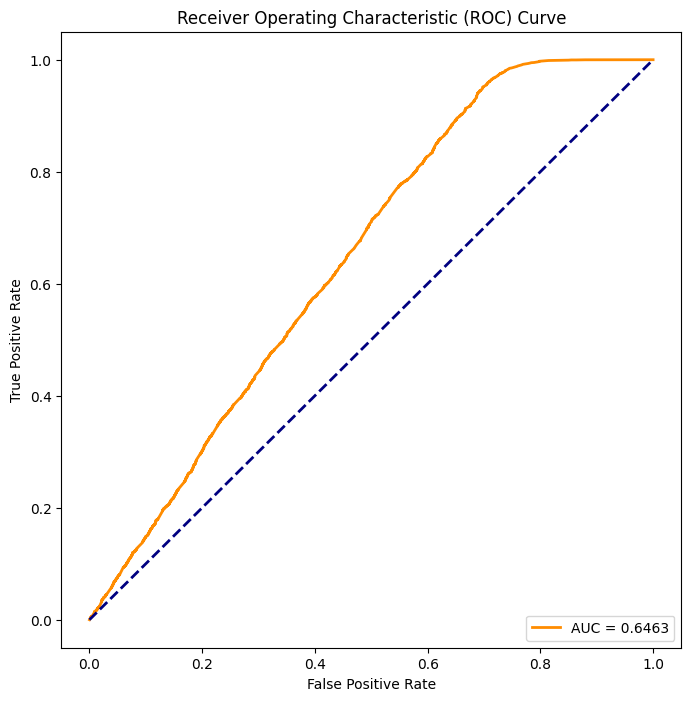

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Convert to PyTorch tensors
attack_inputs_tensor = torch.FloatTensor(attack_inputs)
attack_labels_tensor = torch.LongTensor(attack_labels)

# Combine input and loss data
#attack_data_tensor = torch.cat([attack_inputs_tensor, pred_losses_tensor.view(-1, 1)], dim=1)


X_train, X_test, y_train, y_test = train_test_split(
    attack_inputs_tensor, attack_labels_tensor, test_size=0.2, random_state=42
)
# Convert to numpy arrays
X_train_numpy = X_train.numpy()
y_train_numpy = y_train.numpy().squeeze()
X_test_numpy = X_test.numpy()
y_test_numpy = y_test.numpy().squeeze()

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the RandomForestClassifier
rf_classifier.fit(X_train_numpy, y_train_numpy)


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict on the training set
train_predictions = rf_classifier.predict(X_train_numpy)
print(len(train_predictions))
train_accuracy = accuracy_score(y_train_numpy, train_predictions)
print(f'Train Accuracy (Random Forest): {100 * train_accuracy:.2f}%')

# Predict on the test set
test_predictions = rf_classifier.predict(X_test_numpy)
test_accuracy = accuracy_score(y_test_numpy, test_predictions)
print(f'Test Accuracy (Random Forest): {100 * test_accuracy:.2f}%')

# Calculate AUC-ROC score for the test set
test_proba = rf_classifier.predict_proba(X_test_numpy)[:, 1]  # Probability of the positive class
test_auc_roc = roc_auc_score(y_test_numpy, test_proba)
print(f'AUC-ROC Score (Random Forest): {100 * test_auc_roc:.4f}')

# Calculate AUC-ROC curve for the test set
test_proba = rf_classifier.predict_proba(X_test_numpy)[:, 1]  # Probability of the positive class
fpr, tpr, thresholds = roc_curve(y_test_numpy, test_proba)
roc_auc = auc(fpr, tpr)

# Plot the AUC-ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


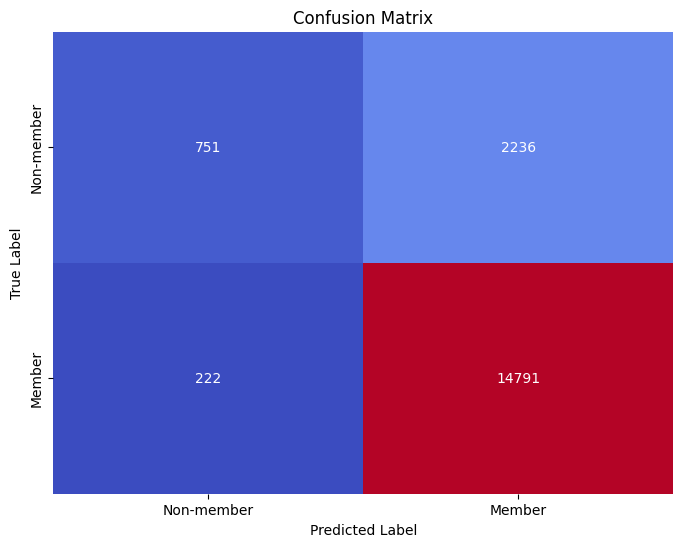

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (previous code)

# # Predict on the test set
# test_predictions = rf_classifier.predict(X_test_numpy)
# test_accuracy = accuracy_score(y_test_numpy, test_predictions)
# print(f'Test Accuracy (Random Forest): {100 * test_accuracy:.2f}%')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_numpy, test_predictions)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Non-member', 'Member'], yticklabels=['Non-member', 'Member'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


NN Classifier

In [15]:
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [16]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size=3):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Combine the member and non-member datasets
attack_prob_input = np.concatenate(
    [predictions_members_1, predictions_members_2, predictions_members_3,
     predictions_non_members_1, predictions_non_members_2, predictions_non_members_3],
    axis=0
)
attack_labels = np.concatenate(
    [labels_members_1, labels_members_2, labels_members_3,
     labels_non_members_1, labels_non_members_2, labels_non_members_3],
    axis=0
)

# Shuffle the data
shuffle_indices = np.random.permutation(len(attack_labels))
attack_inputs = attack_prob_input[shuffle_indices]
attack_labels = attack_labels[shuffle_indices]

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    attack_inputs, attack_labels, test_size=0.2, random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for validation
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Create DataLoader for testing
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")


Number of training samples: 72000
Number of validation samples: 9000
Number of testing samples: 9000


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Model definition
class BinaryClassifier(nn.Module):
    def __init__(self, input_size=3):  # Adjust input_size to match the data size
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Function to train the model
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss += loss_fn(val_outputs, val_labels).item()
                all_preds.extend(val_outputs.argmax(dim=1).cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        accuracy = accuracy_score(all_labels, all_preds)

        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Training Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {accuracy:.4f}')

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = model(test_inputs)
            all_preds.extend(test_outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy:.4f}')

# Initialize the model, loss function, optimizer
binary_model = BinaryClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(binary_model.parameters(), lr=0.001)

# Train the model
train_model(binary_model, train_loader, val_loader, optimizer, loss_fn, epochs=10)

# Evaluate on the test set
evaluate_model(binary_model, test_loader)


Epoch 1/10, Training Loss: 0.4086, Validation Loss: 0.3773, Validation Accuracy: 0.8711
Epoch 2/10, Training Loss: 0.3921, Validation Loss: 0.3726, Validation Accuracy: 0.8717
Epoch 3/10, Training Loss: 0.3886, Validation Loss: 0.3738, Validation Accuracy: 0.8716
Epoch 4/10, Training Loss: 0.3884, Validation Loss: 0.3722, Validation Accuracy: 0.8714
Epoch 5/10, Training Loss: 0.3867, Validation Loss: 0.3729, Validation Accuracy: 0.8707
Epoch 6/10, Training Loss: 0.3863, Validation Loss: 0.3742, Validation Accuracy: 0.8706
Epoch 7/10, Training Loss: 0.3859, Validation Loss: 0.3719, Validation Accuracy: 0.8711
Epoch 8/10, Training Loss: 0.3856, Validation Loss: 0.3714, Validation Accuracy: 0.8726
Epoch 9/10, Training Loss: 0.3861, Validation Loss: 0.3712, Validation Accuracy: 0.8719
Epoch 10/10, Training Loss: 0.3852, Validation Loss: 0.3712, Validation Accuracy: 0.8720
Test Accuracy: 0.8748


In [ ]:
len(attack_inputs)

90000

In [1]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [26]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size=3):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    scheduler.step()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        torch.save(model.state_dict(), "attack_model.pth")
    # 6. Return the filled results at the end of the epochs
    return results


# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

binary_model = BinaryClassifier()
binary_model = binary_model.to(device)

loss_fn = nn.CrossEntropyLoss()
# Create an optimizer
#optimizer = torch.optim.SGD(params=binary_model.parameters(),
                            #lr=0.001)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(binary_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model=binary_model,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS
                      )

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3982 | train_acc: 0.8594 | test_loss: 0.3748 | test_acc: 0.8752
Epoch: 2 | train_loss: 0.3851 | train_acc: 0.8659 | test_loss: 0.3668 | test_acc: 0.8751
Epoch: 3 | train_loss: 0.3840 | train_acc: 0.8663 | test_loss: 0.3667 | test_acc: 0.8742
Epoch: 4 | train_loss: 0.3845 | train_acc: 0.8663 | test_loss: 0.3667 | test_acc: 0.8745
Epoch: 5 | train_loss: 0.3840 | train_acc: 0.8662 | test_loss: 0.3685 | test_acc: 0.8747
Epoch: 6 | train_loss: 0.3840 | train_acc: 0.8664 | test_loss: 0.3664 | test_acc: 0.8745
Epoch: 7 | train_loss: 0.3836 | train_acc: 0.8665 | test_loss: 0.3668 | test_acc: 0.8742
Epoch: 8 | train_loss: 0.3825 | train_acc: 0.8666 | test_loss: 0.3682 | test_acc: 0.8746
Epoch: 9 | train_loss: 0.3825 | train_acc: 0.8665 | test_loss: 0.3673 | test_acc: 0.8743
Epoch: 10 | train_loss: 0.3825 | train_acc: 0.8665 | test_loss: 0.3668 | test_acc: 0.8743
Total training time: 33.859 seconds


In [29]:
Number_of_training_samples = 120000
Number_of_validation_samples = 15000
Number_of_testing_samples = 15000


class BinaryClassifier(nn.Module):
    def __init__(self, input_size=3):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    scheduler.step()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc



def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

binary_model = BinaryClassifier()
binary_model = binary_model.to(device)

loss_fn = nn.CrossEntropyLoss()
# Create an optimizer
#optimizer = torch.optim.SGD(params=binary_model.parameters(),
                            #lr=0.001)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(binary_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=binary_model,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS
                      )

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4523 | train_acc: 0.8321 | test_loss: 0.4341 | test_acc: 0.8386
Epoch: 2 | train_loss: 0.4427 | train_acc: 0.8321 | test_loss: 0.4283 | test_acc: 0.8386
Epoch: 3 | train_loss: 0.4366 | train_acc: 0.8321 | test_loss: 0.4215 | test_acc: 0.8386
Epoch: 4 | train_loss: 0.4284 | train_acc: 0.8345 | test_loss: 0.4111 | test_acc: 0.8473
Epoch: 5 | train_loss: 0.4199 | train_acc: 0.8441 | test_loss: 0.4019 | test_acc: 0.8547
Epoch: 6 | train_loss: 0.4123 | train_acc: 0.8499 | test_loss: 0.3943 | test_acc: 0.8603
Epoch: 7 | train_loss: 0.4059 | train_acc: 0.8540 | test_loss: 0.3880 | test_acc: 0.8629
Epoch: 8 | train_loss: 0.4026 | train_acc: 0.8554 | test_loss: 0.3882 | test_acc: 0.8641
Epoch: 9 | train_loss: 0.4022 | train_acc: 0.8557 | test_loss: 0.3873 | test_acc: 0.8641
Epoch: 10 | train_loss: 0.4017 | train_acc: 0.8559 | test_loss: 0.3871 | test_acc: 0.8647
Total training time: 31.579 seconds


In [30]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

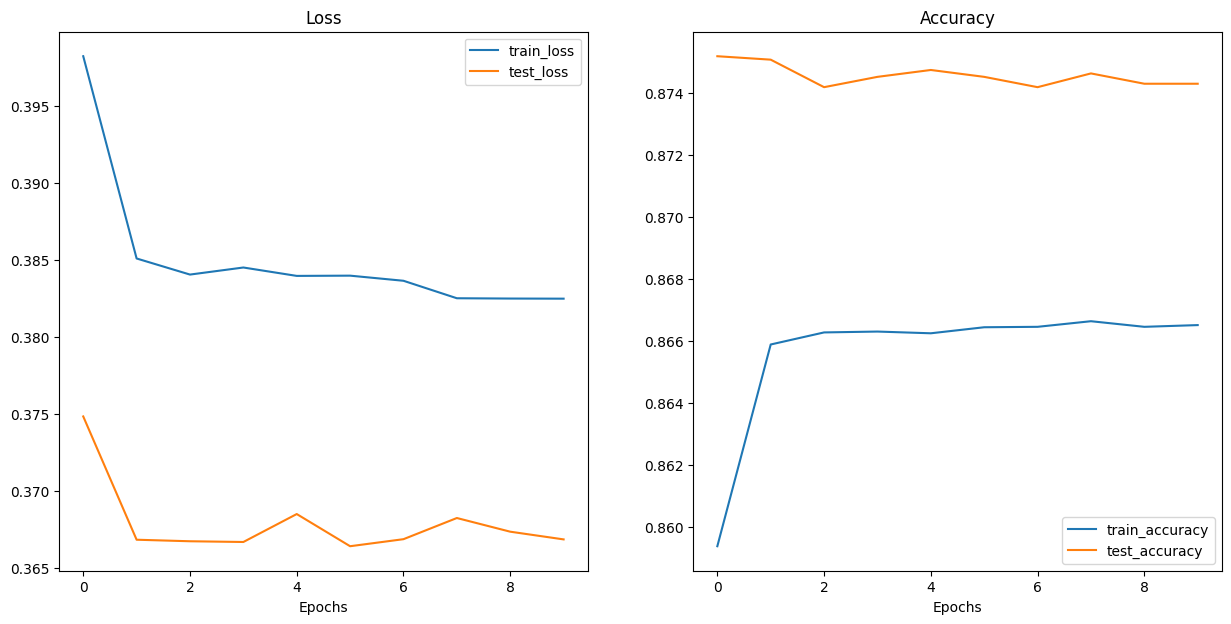

In [ ]:
plot_loss_curves(model_results)

In [22]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.
    """
    loss, acc = 0, 0
    true_labels = []
    predicted_scores = []

    model.eval()
    with torch.inference_mode():
        for inputs, labels in data_loader:
            # Send data to the target device
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            predictions = torch.softmax(logits, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_scores.extend(predictions.cpu().numpy())
            loss += loss_fn(logits, labels)
            acc += accuracy_fn(y_true=labels, y_pred=predictions.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return np.array(true_labels), np.array(predicted_scores), {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc
        }

# Calculate model 1 results with device-agnostic code
true_labels, predicted_scores, model_results = eval_model(model=binary_model, data_loader=test_loader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_results

{'model_name': 'BinaryClassifier',
 'model_loss': 0.3671364486217499,
 'model_acc': 87.48448581560284}

In [ ]:
print(test_loader)

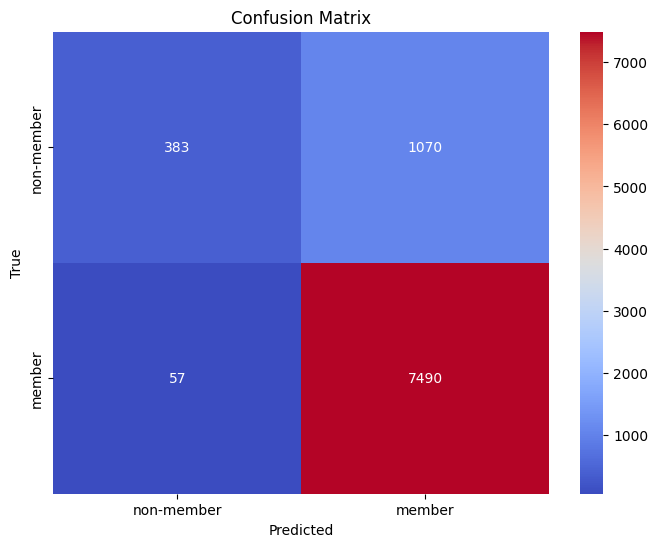

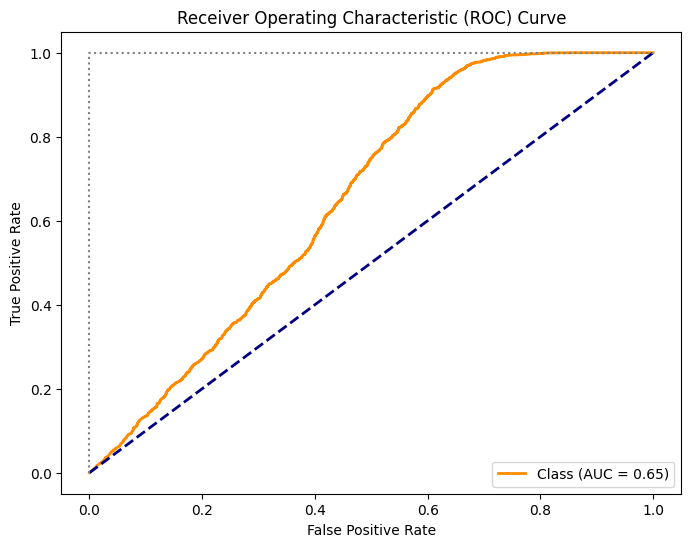

In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_scores, title='Receiver Operating Characteristic (ROC) Curve'):
    plt.figure(figsize=(8, 6))


    fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,color='darkorange', label=f'Class (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color='gray'
         )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

class_names = ['non-member', 'member']

# Get true labels and predicted probabilities for the test set
#true_labels, predicted_scores = get_true_labels_and_scores(binary_model, test_loader)

# Convert predicted probabilities to predicted class labels
predicted_labels = np.argmax(predicted_scores, axis=1)

# Plot confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)

# Plot ROC curve
plot_roc_curve(true_labels, predicted_scores)




In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models
from PIL import Image
from IPython.display import HTML


# Function to load a model
def load_target_model():
    local_path = "weights_resnet18_cifar10.pth"
    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    model = resnet18(weights=None, num_classes=10)
    model.load_state_dict(weights_pretrained)
    model.to(DEVICE)
    model.eval()
    return model

def load_attack_model():
    local_path = './attack_model.pth'
    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    # Initialize the model
    model = BinaryClassifier()
    model.load_state_dict(weights_pretrained)
    model.to(DEVICE)
    model.eval()
    return model

# Function to predict membership

def predict_membership(target_model_path, input_data_path, attack_model_path):
    # Load target model
    target_model = load_target_model()
    # Apply the same transformation used during training
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Preprocess input_data
    with torch.no_grad():
        input_data = Image.open(input_data_path)
        input_data = transform(input_data).unsqueeze(0).to(device)
        target_logits = target_model(input_data)
        target_predictions = torch.softmax(target_logits, dim=1)
        top_k_values, _ = torch.topk(target_predictions, k=3)

    # Load attack model
    attack_model = load_attack_model()

    # Set the attack model to evaluation mode
    attack_model.eval()

    # Forward pass through attack model
    with torch.no_grad():
        attack_logits = attack_model(top_k_values)
        attack_predictions = torch.softmax(attack_logits, dim=1)
        attack_prob = round(torch.max(attack_predictions, dim=1).values[0].item(), 2) * 100
        attack_label = attack_predictions.argmax().item()

    # Check attack model's prediction
    if attack_label == 1:
        result = f'[RESULT] Input is a Member at {attack_prob}% certainty'
        colored_result = f'<font color="green">{result}</font>'
    else:
        result = f'[RESULT] Input is not a Member at {attack_prob}% certainty'
        colored_result = f'<font color="red">{result}</font>'

    display(HTML(colored_result))
def membership_inference():
    # download and pre-process CIFAR10
    # print("Creating sample dataset...")
    # dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
    # download_url(dataset_url, '.')

    # with tarfile.open("./cifar10.tgz", "r:gz") as tar:
    #     tar.extractall(path="./data")

    # Example usage with a datapoint from the CIFAR-10 dataset
    target_model_path = "./weights_resnet18_cifar10.pth"
    attack_model_path = "./attack_model.pth"
    example_image_path = "/content/data/cifar10/test/cat/0004.png"

    # Make the prediction
    predict_membership(target_model_path, example_image_path, attack_model_path)

if __name__ == "__main__":
    membership_inference()
